# OGGM - data pulling

Adds topographical variables from OGGM to the PMB data.

## Setting up:

In [14]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import salem
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks
from oggm import cfg as oggmCfg
import os
import re
import seaborn as sns
import math
from os.path import isfile, join, isdir
from shapely.geometry import Point

from scripts.glamos_preprocess import *

## Download OGGM data:

In [15]:
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir='../../../data/OGGM/',
    rgi_region="11",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)

# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'
df_pmb_50s_clean = pd.read_csv(path_PMB_GLAMOS_csv + f'df_pmb_50s.csv')

export_oggm_grids(df_pmb_50s_clean, gdirs, output_path=path_OGGM_xrgrids)

2025-04-09 14:11:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-09 14:11:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-09 14:11:04: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-09 14:11:04: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-09 14:11:04: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-09 14:11:04: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-04-09 14:11:05: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-04-09 14:11:05: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2025-04-09 14:11:20: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


In [16]:
print('Number of winter and annual samples:', len(df_pmb_50s_clean))
print('Number of annual samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'winter']))

# Get OGGM info of one sample:
RGI = df_pmb_50s_clean.iloc[0].RGIId
# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == RGI:
        break
with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

Number of winter and annual samples: 35270
Number of annual samples: 8636
Number of winter samples: 26634


<xarray.Dataset> Size: 480kB
Dimensions:                  (x: 133, y: 68)
Coordinates:
  * x                        (x) float32 532B -2.077e+03 ... 1.883e+03
  * y                        (y) float32 272B 5.097e+06 5.097e+06 ... 5.095e+06
Data variables: (12/17)
    topo                     (y, x) float32 36kB 2.989e+03 ... 3.613e+03
    topo_smoothed            (y, x) float32 36kB 3.007e+03 ... 3.63e+03
    topo_valid_mask          (y, x) int8 9kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 9kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 9kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 36kB nan nan nan nan ... nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 9kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 9kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 36kB 0.1747 0.1881 ... 0.3885 0.3636
    aspect                   (y, x) float32 36kB 5.814 5.666 ... 3.591 3.477
    slope_factor             (y, x) float32 36kB 2.849 2.725 ... 1.764 1.835
    dis_from_border          (y, x) float32 36kB 1.262e+03 1.253e+03 ... 852.8
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.87661 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      4145.0
    min_h_dem:      2858.0
    max_h_glacier:  4100.0
    min_h_glacier:  2976.0

## Merge with OGGM data:

In [17]:
df_pmb_topo = merge_pmb_with_oggm_data(
    df_pmb=df_pmb_50s_clean,
    gdirs=gdirs,
    rgi_region="11",
    rgi_version="6",
)

# Remove 'pers' glacier
df_pmb_topo = df_pmb_topo.loc[df_pmb_topo.GLACIER != 'pers']

RGI60-11.01450


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


Text(0.5, 1.0, 'Stakes on glacier')

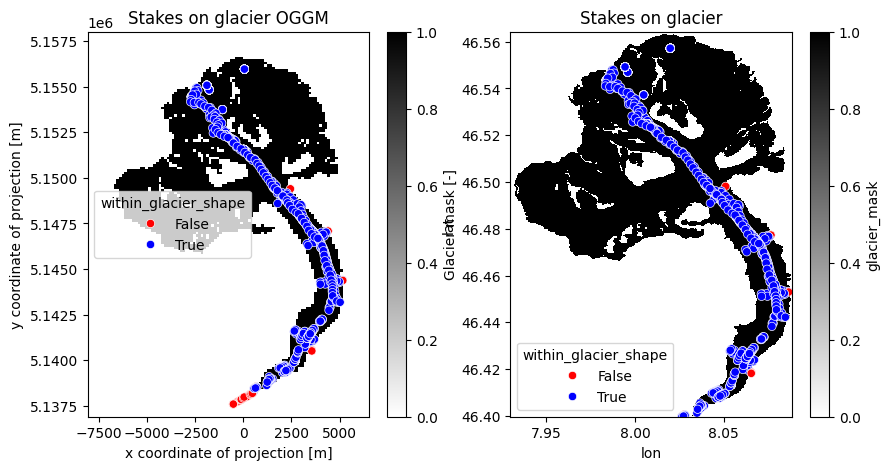

In [18]:
# Example:
glacierName = 'aletsch'
# stakes
df_stakes = df_pmb_50s_clean.copy()
df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]
RGIId = df_stakes.RGIId.unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'../../../data/OGGM/xr_grids/{RGIId}.nc')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes['x'] = x_stake
df_stakes['y'] = y_stake

# plot stakes
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ds_oggm.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='x',
                y='y',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier OGGM')

ax = plt.subplot(122)
path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
sgi_grid = xr.open_dataset(path_SGI_topo +
                           f'xr_masked_grids/{glacierName}.zarr')
sgi_grid.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='POINT_LON',
                y='POINT_LAT',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier')

In [19]:
fname = 'CH_wgms_dataset_oggm.csv'

# Drop points that are not within the glacier shape
df_pmb_topo = df_pmb_topo[df_pmb_topo['within_glacier_shape']]
df_pmb_topo = df_pmb_topo.drop(columns=['within_glacier_shape'])
df_pmb_topo.to_csv(os.path.join(path_PMB_GLAMOS_csv, fname),
                index=False)

## Add SGI data:

/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


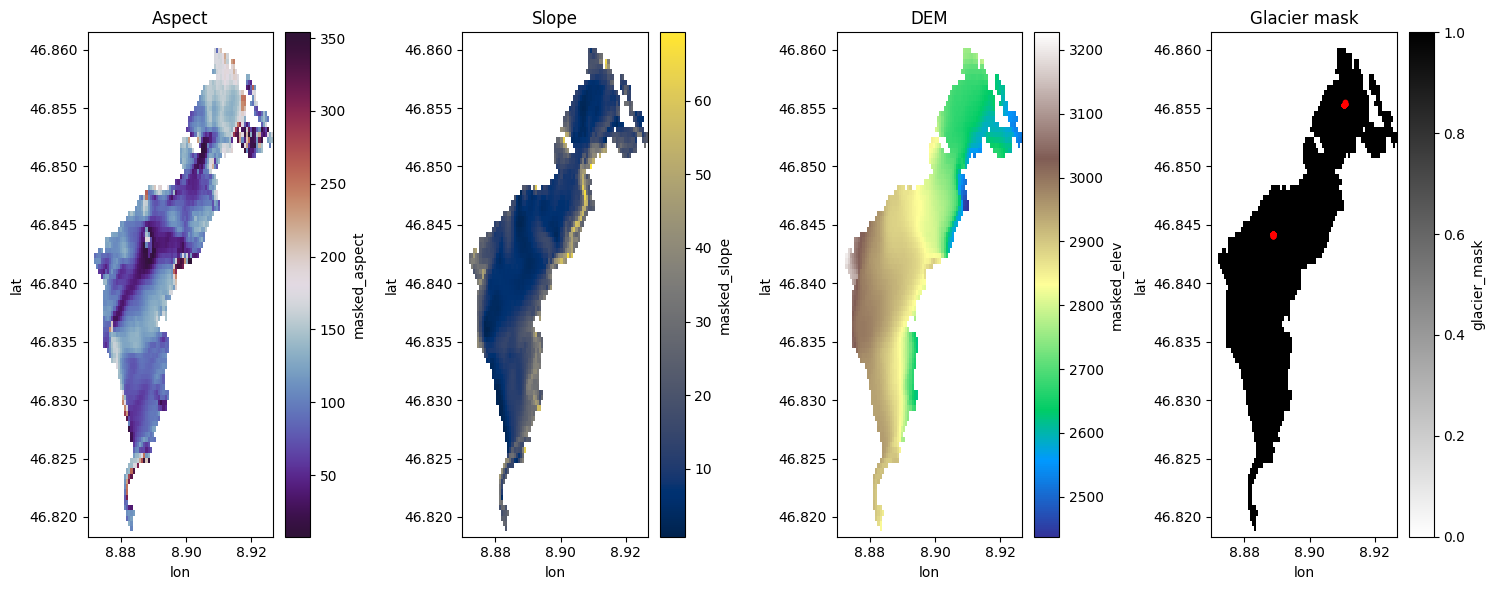

In [20]:
# Example
path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
i = 0
GlacierName = 'clariden'
df_pmb_gl = df_pmb_50s_clean[df_pmb_50s_clean.GLACIER == GlacierName]

stake_coordinates = df_pmb_gl[['POINT_LON', 'POINT_LAT']].values
# Open SGI grid:
ds_sgi = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/' +
                         f'{GlacierName}.zarr')

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_sgi.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_sgi.masked_slope.plot(ax=axs[1], cmap='cividis')
ds_sgi.masked_elev.plot(ax=axs[2], cmap='terrain')
ds_sgi.glacier_mask.plot(ax=axs[3], cmap='binary')
axs[3].scatter(stake_coordinates[:, 0], stake_coordinates[:, 1], c='r', s=10)
axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

In [21]:
df_pmb_topo = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv, 'CH_wgms_dataset_oggm.csv'))
# Paths and variables of interest
path_masked_grids = os.path.join(path_SGI_topo, 'xr_masked_grids/')

# Merge PMB with SGI data
df_pmb_sgi = merge_pmb_with_sgi_data(
df_pmb_topo,  # cleaned PMB DataFrame
path_masked_grids,  # path to SGI grids
voi=["masked_aspect", "masked_slope", "masked_elev"])

Processing glaciers:   0%|          | 0/31 [00:00<?, ?it/s]

/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.11/site-packages/xarray/backends/plugins.py

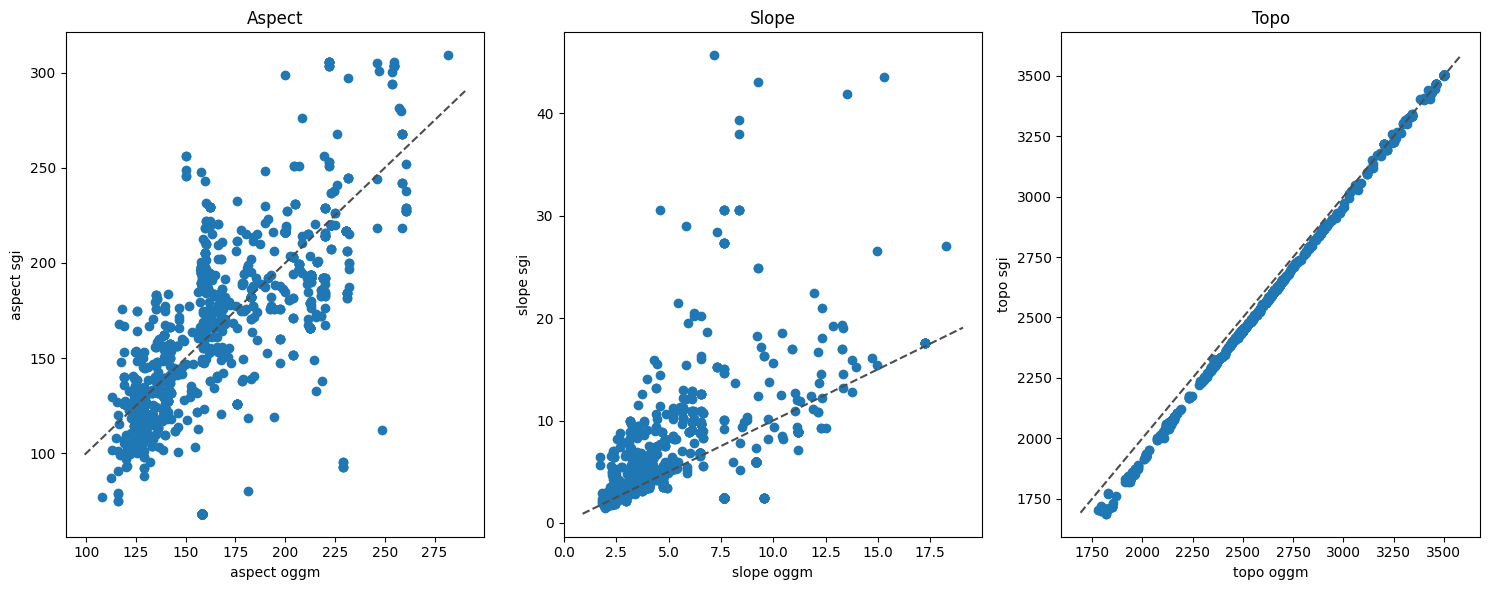

In [22]:
glacierName = 'aletsch'
df_pmb_gl = df_pmb_sgi[(df_pmb_sgi.GLACIER == glacierName)]

# Plot aspect and sgi aspect
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].scatter(df_pmb_gl.aspect, df_pmb_gl.aspect_sgi)
axs[0].set_xlabel('aspect oggm')
axs[0].set_ylabel('aspect sgi')
axs[0].set_title('Aspect')

axs[1].scatter(df_pmb_gl.slope, df_pmb_gl.slope_sgi)
axs[1].set_xlabel('slope oggm')
axs[1].set_ylabel('slope sgi')
axs[1].set_title('Slope')

# same for topo
axs[2].scatter(df_pmb_gl.topo, df_pmb_gl.topo_sgi)
axs[2].set_xlabel('topo oggm')
axs[2].set_ylabel('topo sgi')
axs[2].set_title('Topo')
# add 1:1 line
for ax in axs:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

plt.tight_layout()